In [65]:
#IMPORT NECESSARY PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import pymysql.cursors
import datetime
import matplotlib.gridspec as grd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from time import mktime

In [2]:
#Ask the user for the date range between which data will be pulled from SQL
def get_date_range():
    date1=input("Enter Start Date YYYY-mm-DD: ")
    date2=input("Enter End Date YYYY-mm-DD: ")
    return date1,date2

In [3]:
def sql_connect():
    #Connect to SQL database with username and pw
    mydb = pymysql.connect(
        host='155.98.6.253',
        user='EddyFlux',
        passwd = 'UvTrhM_yFo71X2',
        database = 'CO2_Eddy'
        )
    
    #Set up cursor (allows navigation through SQL syntax)
    mycursor = mydb.cursor()
    
    return mycursor

In [4]:
def get_LI_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" LI_8100 Data         # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, Cdry\
                        FROM {}\
                        WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                        order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    LI_vent = pd.DataFrame(list(data)) #convert imported data to dataframe
    LI_vent.columns = ['Local_DT','EPOCH_TIME','CO2'] #name columns
    cols = LI_vent.columns.drop('Local_DT') #get all column names beside date column
    LI_vent[cols]=LI_vent[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return LI_vent

In [5]:
def get_multiplexer_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Multiplexer Data     # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    #Connect to SQL
    mycursor = sql_connect()   
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Multiplexer = pd.DataFrame(list(data)) #convert imported data into a dataframe
    Multiplexer.columns = ['Local_DT','EPOCH_TIME','CO2_1','CO2_2','CO2_3','Rotations','Wind_Velocity','Wind_Direction','Temp','Location'] #name columns
    cols = Multiplexer.columns.drop('Local_DT') #get all column names but date column
    Multiplexer[cols]=Multiplexer[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Multiplexer

In [6]:
def get_vent_anem_temp_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Vent_Anem_Temp = pd.DataFrame(list(data)) #convert imported data to a dataframe
    Vent_Anem_Temp.columns = ['Local_DT','EPOCH_TIME','Rotations','Velocity','Temp_1','Temp_2'] #name columns
    cols = Vent_Anem_Temp.columns.drop('Local_DT') #get all column names but date
    Vent_Anem_Temp[cols]=Vent_Anem_Temp[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Vent_Anem_Temp

In [7]:
def get_picarro_data(tablename,date1,date2):
    ###################################################################
    # Function to get exclusively "Spike Necessary" Picarro Data from #
    # SQL. Input the SQL Tablename, and date range between which data #
    # will be fetched. For one day's worth of data, enter the same    #
    # Date.                                                           #
    ###################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, CO2_dry, ANEMOMETER_UY\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    Picarro = pd.DataFrame(list(data)) #convert data to a dataframe
    Picarro.columns = ['Local_DT','EPOCH_TIME','CO2','ANEM_Y'] #name columns
    cols = Picarro.columns.drop('Local_DT') #get all column names but date
    Picarro[cols]=Picarro[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Picarro

In [8]:
#Script pulls in all of the necessary data in the date range input into the function
#Inputs: The names of each SQL table
#        date1 - start date for range of data to pull
#        date2 - end date for range of data to pull
def get_sql_data(LI_vent_sql_tablename,Multiplexer_sql_tablename,\
                 Vent_Anem_Temp_sql_tablename,Picarro_sql_tablename,date1,date2):
    
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################

    #Import source (LI_8100_Vent) data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        LI_vent = get_LI_data(LI_vent_sql_tablename,date1,date2)
    except ValueError:
        LI_vent = pd.DataFrame() #set empty dataframe
        pass
    
    
    #Import Multiplexer data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Multiplexer = get_multiplexer_data(Multiplexer_sql_tablename,date1,date2)
    except ValueError:
        Multiplexer = pd.DataFrame() #make empty dataframe
        pass
    
    #Import Vent_Anem_Temp data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Vent_Anem_Temp = get_vent_anem_temp_data(Vent_Anem_Temp_sql_tablename,date1,date2)
    except ValueError:
        Vent_Anem_Temp = pd.DataFrame() #make empty dataframe
        pass

    
    #Import Picarro data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Picarro = get_picarro_data(Picarro_sql_tablename,date1,date2)
    except ValueError:
        Picarro = pd.DataFrame() #make empty dataframe
        pass
    
    return LI_vent, Multiplexer, Vent_Anem_Temp, Picarro #return all of the fetched dataframes

In [9]:
#Plot a simple graph with local_dt on the x axis, and an input (y_ax) on the y axis
def simple_plot(df,y_ax):
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df['Local_DT'],df[y_ax]) #plot
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()

In [10]:
#Make a figure of multiple plots plotted above one another. X axes have the same values
def plot_vertical_stack(df):
    if 'CO2_1' in df: #if there is CO2_1, we are in multiplexer data, and want three plots, one for each CO2 value of muliplexer
        fig = plt.figure(figsize=(15,5)) #set fig, ax with a figsize
        gs = grd.GridSpec(3,1) # three plots
        ax = fig.add_subplot(gs[0]) # add first subplot
        ax.plot(df['Local_DT'],df['CO2_1'],color='blue') #plot first subplot
        ax = fig.add_subplot(gs[1],sharex=ax) #make second subplot with same xaxis as first
        ax.plot(df['Local_DT'],df['CO2_2'],color='red')
        ax = fig.add_subplot(gs[2],sharex=ax)
        ax.plot(df['Local_DT'],df['CO2_3'],color='black')
        plt.gcf().autofmt_xdate() #format the date
        fig.tight_layout()
        plt.show()
    else :
        fig = plt.figure(figsize=(10,5))
        gs = grd.GridSpec(2,1)
        ax = fig.add_subplot(gs[0])
        ax.plot(df['Local_DT'],df['CO2'],color='blue')
        ax = fig.add_subplot(gs[1],sharex=ax)
        ax.plot(df['Local_DT'],df['ANEM_Y'],color='red')
        plt.gcf().autofmt_xdate()
        fig.tight_layout()
        plt.show()

In [11]:
#This function allows the user to specify the range over which to plot picarro data
def plot_refinement_picarro(df):
    #plot_vertical_stack(df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref: #continue asking user to refine until command is given
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plot_vertical_stack(df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
    
    return df1 #return the df with the user chosen range

In [12]:
#This function allows the user to specify the range over which to plot LI data
def plot_refinement_LI(df):
    fig = plt.figure()
    plt.plot(df['Local_DT'],df['CO2'])  #plot the data
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show()
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref:       #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ")  #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ")   #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plt.plot(df1['Local_DT'],df1['CO2']) #plot over that range
        plt.gcf().autofmt_xdate()
        fig.tight_layout()
        plt.show()
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [13]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_multiplexer(df):
    plot_vertical_stack(df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plot_vertical_stack(df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [14]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_vent_anem_temp(df):
    simple_plot(df,'Velocity') #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        simple_plot(df1,'Velocity') #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [15]:
#This function refines all dataframes to user specified ranges
def get_tighter_ranges(LI_vent, LI_remote, Multiplexer, Picarro):
    Picarro = plot_refinement_picarro(Picarro) #refine picarro range
    LI_vent = plot_refinement_LI(LI_vent) #refine LI_vent range
    Multiplexer = plot_refinement_multiplexer(Multiplexer) #refine Multiplexer range
    return LI_vent, LI_remote, Multiplexer, Picarro         #return the refined range dataframes for each dataframe

In [16]:
# This function gets a single "spike" from picarro anemometer data
# Input: Picarro style dataframe
# Output: List of the selected EPOCH time associated with the spike
def get_single_pic_anem_spikes(df):
    
    df = df.reset_index(drop=True) # reset the index
    y_ax = 'ANEM_Y'  # set the y_ax to ANEM_Y - this is where spikes are generally input             

    simple_plot(df,y_ax)  # plot the data

    #This is one method for "spiking" the anem data. We unplug the serial cable so the value
    #pauses during that time. Therefore we check for where the value remains the same over a 
    #given time
    df['shift'] = df['ANEM_Y'].shift(-15)   #create a column shifted 10 seconds later 
    df['shift2'] = df['ANEM_Y'].shift(-5)   #create a column shifted 5 seconds later

    spike_ixs = np.where((df['ANEM_Y']==df['shift'])&(df['ANEM_Y']==df['shift2']))[0]  #check to see where ANEM_Y values are  
                                                                                       #equal to the ANEM_Y values 5 and 10
                                                                                       #seconds later. Store in a list. 

    #initialize some variables
    num_spikes = 0
    spike_start = []
    spike_end = []
    spike_start.append(spike_ixs[0])

    #Count number of spikes (sustained same value without large gap)
    #Append the start of each spike and end of each spike to created arrays
    for i in range(0,len(spike_ixs)-2):
        if (spike_ixs[i+1]-spike_ixs[i]>20):
            spike_end.append(spike_ixs[i])
            num_spikes += 1
            spike_start.append(spike_ixs[i+1])
    spike_end.append(spike_ixs[-1])  
    spikes = pd.DataFrame({'Start':spike_start, 'End':spike_end}, columns =['Start','End'])

    #Create a list of dataframes. Each dataframe is the range around the spike. It is "r" 
    #datapoints (in this case 0.1s) before the spike start and "r" datapoints after the 
    #spike end
    r = 30 #set r
    df_list = {}
    for i in range(0,len(spikes)):
        df_list[i] = df[spikes['Start'][i]-r:spikes['End'][i]+r] #get the range

    #create a list of spike starts so we don't have to keep referencing into the spikes dataframe
    st_spike_idx = []
    for i in range(0,len(df_list)):
        st_spike_idx.append(spikes['Start'][i] - 1)  #append the start of each spike

    #Here we will ask the user if the spike is in the correct spot
    for j in range(0,len(spikes)):
        refine = True
        while refine:       
            ANEM = []
            ET = []

            for i in range(0,len(spikes)):
                ET.append(df['EPOCH_TIME'][st_spike_idx[i]])
                ANEM.append(df['ANEM_Y'][st_spike_idx[i]])
            plot_spike_with_pts(df_list[j],ET[j],ANEM[j],'ANEM_Y')

            ask = input("Is the spike start in the correct spot?")
            if ask == 'y':
                refine = False
            else:
                spike_refine = int(input("Spike Index Move: "))
                st_spike_idx[j] = st_spike_idx[j] + spike_refine
    return ET #return the list of spike start EPOCH times


In [17]:
# This function gets a single "spike" from picarro CO2 data
# Input: Picarro style dataframe
# Output: List of the selected EPOCH time associated with the spike 
def get_single_LI_spike(df):
    df = df.reset_index(drop=True) #reset index
    y_ax = 'CO2' #looking at CO2 data

    simple_plot(df,y_ax) #plot the data for reference
    
    threshold = float(input("Enter the threshold value which all spikes go above: ")) #have the user input a threshold above which the spike goes
    
    spike_ixs = np.where((df['CO2']>=threshold) | (df['CO2']<0))[0] #find the indidcies where CO2 value is above input threshold

    num_spikes = 0
    spike_start = []
    spike_end = []
    spike_start.append(spike_ixs[0])

    #Count number of spikes (sustained values above threshold without large gap)
    #Append the start of each spike and end of each spike to created arrays
    for i in range(0,len(spike_ixs)-2):
        if (spike_ixs[i+1]-spike_ixs[i]>3):
            spike_end.append(spike_ixs[i])
            num_spikes += 1
            spike_start.append(spike_ixs[i+1])
    spike_end.append(spike_ixs[-1])  
    
    #create a spikes dataframe with start, center, and end indicies
    spikes = pd.DataFrame({'Start':spike_start, 'End':spike_end}, columns =['Start','End'])
    spikes['Center'] = spikes.apply(lambda row: int((row.Start + row.End)/2),axis=1)

    #Create a list of dataframes. Each dataframe is the range around the spike. It is "r" 
    #datapoints (in this case 0.1s) before the spike start and "r" datapoints after the 
    #spike end
    r = 10
    df_list = {}
    for i in range(0,len(spikes)):
        df_list[i] = df[spikes['Start'][i]-r:spikes['End'][i]+r]   
    
    #create a list of spike starts so we don't have to keep referencing into the spikes dataframe
    st_spike_idx = []
    for i in range(0,len(df_list)):
        co2_diff = abs(df_list[i][y_ax][spikes['Start'][i]] - df_list[i][y_ax][spikes['Start'][i]-1]) #get the difference between point i and i+1
        st_spike_idx.append(spikes['Start'][i] - 1) #append the index value for the start of the spike to the list
        while co2_diff > 1000: #we want to find where the change is large - so where the change between points is greater than 1000, keep moving backward
            co2_diff = abs(df_list[i][y_ax][st_spike_idx[i]] - df_list[i][y_ax][st_spike_idx[i]-1]) #find the difference between the current value and the point before. 
            st_spike_idx[i] = st_spike_idx[i]-1 #increment the index backward
        st_spike_idx[i] += 1 #once the difference is less than 1000, store the next value as the start of the spike

    #Here we will ask the user if the spike is in the correct spot
    for j in range(0,len(spikes)):
        refine = True
        while refine:       
            CO2 = []
            ET = []

            for i in range(0,len(spikes)):
                ET.append(df['EPOCH_TIME'][st_spike_idx[i]])
                CO2.append(df['CO2'][st_spike_idx[i]])
            plot_spike_with_pts(df_list[j],ET[j],CO2[j],'CO2')

            ask = input("Is the spike start in the correct spot?")
            if ask == 'y':
                refine = False
            else:
                spike_refine = int(input("Spike Index Move: "))
                st_spike_idx[j] = st_spike_idx[j] + spike_refine
    
    return ET


In [18]:
def plot_spike_with_pts(df_list,ET,y_ax_var,y_ax_str):
    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(df_list['EPOCH_TIME'],df_list[y_ax_str],color='blue')
    ax.scatter(df_list['EPOCH_TIME'],df_list[y_ax_str],color='red')        
    ax.scatter(ET,y_ax_var,color='black')    
    fig.subplots_adjust()
    plt.show()

In [19]:
def get_single_pic_co2_spikes(df):
    
    df = df.reset_index(drop=True)
    y_ax = 'CO2'

    simple_plot(df,y_ax)


    threshold = float(input("Enter the threshold value which all spikes go above: "))
    spike_ixs = np.where(df['CO2']>=threshold)[0]

    num_spikes = 0
    spike_start = []
    spike_end = []
    spike_start.append(spike_ixs[0])

        #Count number of spikes (sustained -99.99 values without large gap)
        #Append the start of each spike and end of each spike to created arrays
    for i in range(0,len(spike_ixs)-2):
        if (spike_ixs[i+1]-spike_ixs[i]>20):
            spike_end.append(spike_ixs[i])
            num_spikes += 1
            spike_start.append(spike_ixs[i+1])
    spike_end.append(spike_ixs[-1])  
    spikes = pd.DataFrame({'Start':spike_start, 'End':spike_end}, columns =['Start','End'])


    df_list = {}
    for i in range(0,len(spikes)):
        df_list[i] = df[spikes['Start'][i]-30:spikes['End'][i]+30]

    st_spike_idx = []
    for i in range(0,len(df_list)):
        co2_diff = df_list[i]['CO2'][spikes['Start'][i]] - df_list[i]['CO2'][spikes['Start'][i]-1]
        st_spike_idx.append(spikes['Start'][i] - 1)
        while co2_diff > 1000:
            co2_diff = df_list[i]['CO2'][st_spike_idx[i]] - df_list[i]['CO2'][st_spike_idx[i]-1]
            st_spike_idx[i] = st_spike_idx[i]-1
        st_spike_idx[i] += 1

    for j in range(0,len(spikes)):
        refine = True
        while refine:       
            CO2 = []
            ET = []

            for i in range(0,len(spikes)):
                ET.append(df['EPOCH_TIME'][st_spike_idx[i]])
                CO2.append(df['CO2'][st_spike_idx[i]])
            plot_spike_with_pts(df_list[j],ET[j],CO2[j],'CO2')

            ask = input("Is the spike start in the correct spot?")
            if ask == 'y':
                refine = False
            else:
                spike_refine = int(input("Spike Index Move: "))
                st_spike_idx[j] = st_spike_idx[j] + spike_refine

    return ET


In [20]:
def get_single_multiplexer_spike(df,y_ax):
    df = df.reset_index(drop=True)

    simple_plot(df,y_ax)

    threshold = float(input("Enter the threshold value which all spikes go above: "))
    spike_ixs = np.where((df[y_ax]>=threshold))[0]

    num_spikes = 0
    spike_start = []
    spike_end = []
    spike_start.append(spike_ixs[0])

    for i in range(0,len(spike_ixs)-2):
        if (spike_ixs[i+1]-spike_ixs[i]>2):
            spike_end.append(spike_ixs[i])
            num_spikes += 1
            spike_start.append(spike_ixs[i+1])
    spike_end.append(spike_ixs[-1])  
    spikes = pd.DataFrame({'Start':spike_start, 'End':spike_end}, columns =['Start','End'])
    spikes['Center'] = spikes.apply(lambda row: int((row.Start + row.End)/2),axis=1)

    print(spikes)
    
    df_list = {}
    for i in range(0,len(spikes)):
        df_list[i] = df[spikes['Start'][i]-5:spikes['End'][i]+5]

        
    st_spike_idx = []
    for i in range(0,len(df_list)):
        co2_diff = abs(df_list[i][y_ax][spikes['Start'][i]] - df_list[i][y_ax][spikes['Start'][i]-1])
        st_spike_idx.append(spikes['Start'][i] - 1)
        while co2_diff > 200:
            co2_diff = abs(df_list[i][y_ax][st_spike_idx[i]] - df_list[i][y_ax][st_spike_idx[i]-1])
            st_spike_idx[i] = st_spike_idx[i]-1
        st_spike_idx[i] += 1

    for j in range(0,len(spikes)):
        refine = True
        while refine:       
            CO2 = []
            ET = []
            for i in range(0,len(spikes)):
                ET.append(df['EPOCH_TIME'][st_spike_idx[i]])
                CO2.append(df[y_ax][st_spike_idx[i]])

            fig = plt.figure(figsize=(15,len(spikes)*3))
            gs = grd.GridSpec(len(spikes),1)
            #for i in range(0,len(df_list)):
            ax = fig.add_subplot(gs[j])
            ax.plot(df_list[j]['EPOCH_TIME'],df_list[j][y_ax],color='blue')
            ax.scatter(df_list[j]['EPOCH_TIME'],df_list[j][y_ax],color='red')
            ax.scatter(ET[j],CO2[j],color='black')    
            fig.subplots_adjust()
            plt.show()

            ask = input("Is the spike start in the correct spot?")
            if ask == 'y':
                refine = False
            else:
                spike_refine = int(input("Spike Index Move: "))
                st_spike_idx[j] = st_spike_idx[j] + spike_refine          

    return ET


In [21]:
def get_all_multiplexer_spikes(df):
    multi_spike_ET = {}
    for i in range(1,4):
        multi_spike_ET[i] = get_single_multiplexer_spike(df,"CO2_{}".format(i))

    return multi_spike_ET

In [45]:
def get_single_vent_anem_temp_spike(df,y_ax):
    df = df.reset_index(drop=True)
    
    #Plot for visualization
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df['Local_DT'],df[y_ax]) #plot
    ax.scatter(df['Local_DT'],df[y_ax],color='Black')
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()
    
    #confirm spike or dip
    redo = True
    while redo:
        up_or_down = input("Is this a spike or a dip? ")
        if up_or_down == 'spike':
            threshold = float(input("Enter the threshold value which all spikes go above: "))
            spike_ixs = np.where(df[y_ax]>=threshold)[0] #If it's a spike, get the indecies of all values above the input threshold
            first_rot = df['Rotations'].loc[spike_ixs[0]] #Store the number of rotations recorded for the first "spike" index
            rot_tot = df.loc[spike_ixs[0]:spike_ixs[-1]].sum()['Rotations'] #Get the sum of all rotations recorded during the spike
            rot_p_sec = rot_tot/10 #The spike is a 10 second run, divide by 10 to get a "rotations per second" value
            sec_before = int(round(first_rot/rot_p_sec)) #Find the amount of time before the initial spike epoch time when the spike started (number of rotations in first 
                                                        # spike recording divided by spikes per second)
            redo = False
        elif up_or_down == 'dip':
            threshold = float(input("Enter the threshold value which all spikes go below: "))
            spike_ixs = np.where(df[y_ax]<=threshold)[0] #If it's a dip, get the indecies of all values below the input threshold
            if len(spike_ixs) == 1:
                sec_before = df['EPOCH_TIME'].loc[spike_ixs[0]]-df['EPOCH_TIME'].loc[spike_ixs[0]-1]
            else: 
                before_ix = spike_ixs[0]-1
                after_ix =spike_ixs[-1]+1
                before_rot = df['Rotations'].loc[before_ix] #Get the numer of rotations before the spike began to use in average
                after_rot = df['Rotations'].loc[after_ix] #Get the number of rotations after the spike ended to use in average
                average_rot = (before_rot+after_rot)/2 #get the average number of rotations surrounding the dip

                first_rot_diff = before_rot - df['Rotations'].loc[spike_ixs[0]] #Store the difference in number of rotations recorded for the first "spike" index
                last_rot_diff = after_rot - df['Rotations'].loc[spike_ixs[-1]]

                rot_tot = first_rot_diff+last_rot_diff #Get the sum of all rotations recorded during the spike subtracted from twice the average
                rot_p_sec = rot_tot/10 #The spike is a 10 second run, divide by 10 to get a "rotations per second" value
                sec_before = int(round(first_rot_diff/rot_p_sec)) #Find the amount of time before the initial spike epoch time when the spike started (number of rotations in first 
                                                            # spike recording divided by spikes per second)
            redo = False
        else:
            print("Didn't enter spike or dip correctly.")
            redo = True

    
    
    ET = []
    ET.append(df['EPOCH_TIME'].loc[spike_ixs[0]]-sec_before) #Append the spike time. This is the spike start epoch time minus the seconds before as calculated above. 
                                                            # the reason this is subtracted is that the time on the arduino is recorded at the END of the averaging scheme
                                                            # meaning that the count recorded is the count between the previous time and the time recorded for that count
    print(ET)
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df['EPOCH_TIME'],df[y_ax]) #plot
    ax.scatter(df['EPOCH_TIME'],df[y_ax],color='Black')
    plt.axvline(x=ET[0],color='red')
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()
    
    return ET


In [23]:
def spike_ET_df_creation(**kwargs):
    spike_ET_df = pd.DataFrame()
    for key, value in kwargs.items():
        if 'ANEM' in key :
            spike_ET_df['Picarro_ANEM'] = get_single_pic_anem_spikes(value)
            print("1",spike_ET_df)
        elif 'CO2' in key:
            spike_ET_df['Picarro_CO2']= get_single_pic_co2_spikes(value)   
        elif 'vent' in key:
            spike_ET_df['LI_8100_Vent']= get_single_LI_spike(value)
        elif 'remote' in key:
            spike_ET_df['LI_8100_Remote']= get_single_LI_spike(value)
        elif 'Multiplexer' in key:
            #spike_ET_df['Multiplexer_CO2_1'] = get_single_multiplexer_spike(value,'CO2_1')
            multi_spikes = get_all_multiplexer_spikes(value)
            for i in range(1,4):
                spike_ET_df['Multiplexer_CO2_{}'.format(i)] = multi_spikes[i]
        elif 'Temp' in key:
            spike_ET_df['Vent_Anem_Temp'] = get_single_vent_anem_temp_spike(value,'Rotations')
        
    return spike_ET_df

In [24]:
def fill_multiplexer_gaps(df):
    df.EPOCH_TIME = df.EPOCH_TIME.astype(int)
    st = df['EPOCH_TIME'].min()
    end =  df['EPOCH_TIME'].max()
    x = df.set_index('EPOCH_TIME').reindex(range(st,end,1)).interpolate().rename_axis('EPOCH_TIME').reset_index()

    x['Local_DT'] = pd.to_datetime(x['EPOCH_TIME'],unit='s') - pd.Timedelta('06:00:00')

    return x


In [25]:
def create_lag_df(actual_spike_df):
    cols = actual_spike_df.columns.drop(['Actual_DT','Actual_ET'])
    lags = pd.DataFrame()
    lags['Actual_DT'] = actual_spike_df['Actual_DT']
    lags['Actual_ET'] = actual_spike_df['Actual_ET']
    for col in cols:
        lags[col] = actual_spike_df['Actual_ET'] - actual_spike_df[col]


    return lags

In [70]:
def append_real_DT(spike_ET_df,actual_spike_df):
    actual_DT = []
    for i in range(0,len(spike_ET_df)):
        actual_DT.append(input('Actual datetime for this ({}) spike? '.format(i)))

    actual_DT_df = pd.DataFrame({'Actual_DT':actual_DT})
    df_to_append = pd.concat([actual_DT_df,spike_ET_df],axis=1)

    actual_spike_df = actual_spike_df.append(df_to_append,sort=True).reset_index(drop=True)
    
    actual_spike_df['Actual_ET'] = actual_spike_df.apply(lambda row: mktime(datetime.strptime(row['Actual_DT'],"%Y-%m-%d %H:%M:%S").timetuple()),axis=1)

    #actual_spike_df['Actual_ET'] = (pd.to_datetime(actual_spike_df['Actual_DT']).astype(np.int64)) // 10**9+21600
    
    
    return actual_spike_df


In [27]:
def create_actual_spike(arg1,**kwargs):    
    for key, value in kwargs.items():
        if 'CO2' in key :
            Picarro_clip = plot_refinement_picarro(value)
            spike_ET_df = spike_ET_df_creation(Picarro_CO2_df = Picarro_clip)       
        elif 'ANEM' in key:
            Picarro_clip = plot_refinement_picarro(value)
            spike_ET_df = spike_ET_df_creation(Picarro_ANEM_df = Picarro_clip)    
            print("2",spike_ET_df)
        elif 'vent' in key:
            LI_vent_clip = plot_refinement_LI(value)
            spike_ET_df = spike_ET_df_creation(LI_vent_df = LI_vent_clip)
        elif 'remote' in key:
            LI_remote_clip = plot_refinement_LI(value)
            spike_ET_df = spike_ET_df_creation(LI_remote_df = LI_remote_clip)
        elif 'Multiplexer' in key:
            Multiplexer_clip = plot_refinement_multiplexer(value)
            Multiplexer_clip = fill_multiplexer_gaps(Multiplexer_clip)
            spike_ET_df = spike_ET_df_creation(Multiplexer_df = Multiplexer_clip)
        elif 'Temp' in key:
            Vent_Anem_Temp_clip = plot_refinement_vent_anem_temp(value)
            spike_ET_df = spike_ET_df_creation(Vent_Anem_Temp_df = Vent_Anem_Temp_clip)
        arg1 = append_real_DT(spike_ET_df,actual_spike_df)
    return arg1

In [ ]:
date1,date2 = get_date_range()
LI_vent, Multiplexer, Vent_Anem_Temp, Picarro, \
= get_sql_data("Aug2019_LI_8100_Vent",\
               "Aug2019_Multiplexer","Aug2019_Vent_Anem_Temp",\
               "Aug2019_Picarro",date1,date2)
#LI_vent = get_LI_data('Aug2019_LI_8100_Vent',date1,date2)


Enter Start Date YYYY-mm-DD:  2019-11-03
Enter End Date YYYY-mm-DD:  2019-11-15


In [109]:
#actual_spike_df = pd.DataFrame(columns=['Actual_DT','Actual_ET','Picarro_ANEM','Picarro_CO2','LI_8100_Vent','Multiplexer_CO2_1','Multiplexer_CO2_2','Multiplexer_CO2_3'])
actual_spike_df = pd.read_pickle('All_actualET_Spikes.pkl')
actual_spike_df

,Actual_DT,Actual_ET,LI_8100_Vent,Multiplexer_CO2_1,Multiplexer_CO2_2,Multiplexer_CO2_3,Picarro_ANEM,Picarro_CO2,Vent_Anem_Temp
0,2019-08-15 09:55:00,1.565884e+09,NaN,NaN,NaN,NaN,NaN,1.56588e+09,NaN
1,2019-08-15 09:56:00,1.565885e+09,NaN,NaN,NaN,NaN,NaN,1.56588e+09,NaN
2,2019-08-15 09:57:00,1.565885e+09,NaN,NaN,NaN,NaN,NaN,1.56588e+09,NaN
3,2019-08-15 16:55:00,1.565910e+09,NaN,NaN,NaN,NaN,NaN,1.56591e+09,NaN
4,2019-08-15 16:56:00,1.565910e+09,NaN,NaN,NaN,NaN,NaN,1.56591e+09,NaN
5,2019-08-15 16:57:00,1.565910e+09,NaN,NaN,NaN,NaN,NaN,1.56591e+09,NaN
6,2019-08-16 09:39:00,1.565970e+09,NaN,NaN,NaN,NaN,NaN,1.56597e+09,NaN
7,2019-08-16 09:40:00,1.565970e+09,NaN,NaN,NaN,NaN,NaN,1.56597e+09,NaN
8,2019-08-16 09:41:00,1.565970e+09,NaN,NaN,NaN,NaN,NaN,1.56597e+09,NaN
9,2019-08-16 17:17:00,1.565997e+09,NaN,NaN,NaN,NaN,NaN,1.566e+09,NaN


In [111]:
# actual_spike_df = create_actual_spike(actual_spike_df,Vent_Anem_Temp_df=Vent_Anem_Temp)
# more_spikes = input("More Vent_Anem_Temp spikes? ")
# while more_spikes == 'y':
#     actual_spike_df = create_actual_spike(actual_spike_df,Vent_Anem_Temp_df=Vent_Anem_Temp)
#     more_spikes = input("More Vent_Anem_Temp spikes? ")
    
actual_spike_df = create_actual_spike(actual_spike_df,Picarro_CO2_df = Picarro)
more_spikes = input("More Picarro spikes? ")
while more_spikes == 'y':
    actual_spike_df = create_actual_spike(actual_spike_df,Picarro_CO2_df = Picarro)
    more_spikes = input("More Picarro spikes? ")
    
# actual_spike_df = create_actual_spike(actual_spike_df,Picarro_ANEM_df = Picarro)
# more_spikes = input("More Picarro spikes? ")
# while more_spikes == 'y':
#     actual_spike_df = create_actual_spike(actual_spike_df,Picarro_ANEM_df = Picarro)
#     more_spikes = input("More Picarro spikes? ")
    
# actual_spike_df = create_actual_spike(actual_spike_df,Multiplexer_df = Multiplexer)
# more_spikes = input("More Multiplexer spikes? ")
# while more_spikes == 'y':
#     actual_spike_df = create_actual_spike(actual_spike_df,Multiplexer_df = Multiplexer)
#     more_spikes = input("More Multiplexer spikes? ")

# actual_spike_df = create_actual_spike(actual_spike_df,LI_vent_df = LI_vent)
# more_spikes = input("More LI_vent spikes? ")
# while more_spikes == 'y':
#     actual_spike_df = create_actual_spike(actual_spike_df,LI_vent_df = LI_vent)
#     more_spikes = input("More LI_vent spikes? ")


Is this an acceptable range?  d
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  d
Input End DateTime as YYYY-mm-DD HH:MM:SS -  d


TypeError: Invalid comparison between dtype=datetime64[ns] and str

In [77]:
#actual_spike_df.drop(len(actual_spike_df)-1,inplace=True)


In [110]:
lags = create_lag_df(actual_spike_df)
pd.set_option('display.max_rows', 1000)
lags[['Actual_DT','Picarro_CO2']].dropna().tail()

,Actual_DT,Picarro_CO2
563,2019-10-29 08:15:00,-145.7
564,2019-10-29 08:16:00,-145.4
565,2019-10-30 18:52:00,-145.3
566,2019-10-30 18:53:00,-145.4
567,2019-10-30 18:54:00,-145.3


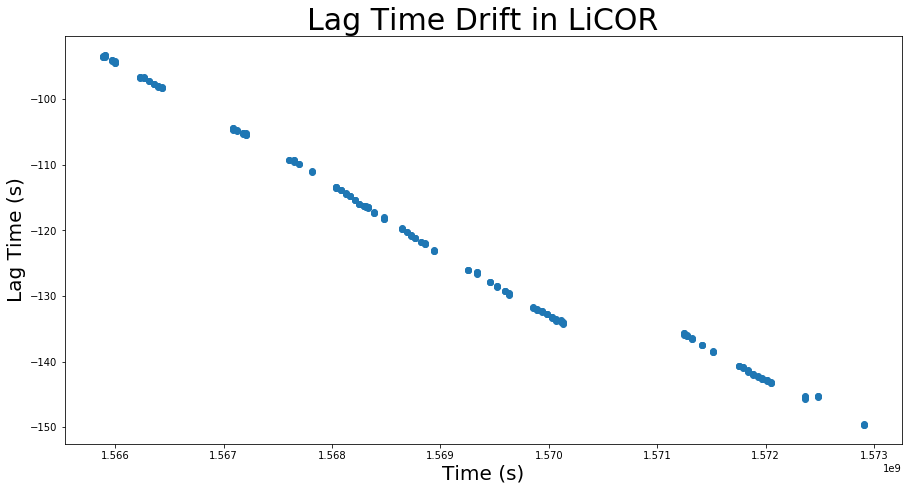

In [106]:
fig,ax=plt.subplots(figsize=[15,7.5])
ax.scatter(lags['Actual_ET'],lags['Picarro_CO2'])
#ax.scatter(lags['Actual_ET'],lags['Picarro_CO2'],color = 'red')
ax.set_ylabel('Lag Time (s)',size=20)
ax.set_xlabel('Time (s)',size=20)
ax.set_title('Lag Time Drift in LiCOR',size=30)
plt.show()

In [103]:
pd.to_pickle(actual_spike_df,'All_actualET_Spikes.pkl')
